# Example application to cell composition data

In this example, we will look at the compositions of samples from a non-small cell lung cancer dataset.

The data orirginates from to [this study](https://www.sciencedirect.com/science/article/pii/S1535610822004998?via%3Dihub). It was subsequently added to [cellxgene](https://cellxgene.cz), which is the source we have taken the data from. The data on cellxgene is gene expression, but also includes cell type labels for each cell. From this we derived the relative cell type composition of each sample, the proportion of each cell type in each sample.

In [1]:
from cvanmf import denovo, combine, data, stability
import pandas as pd
import plotnine as pn
import numpy as np
import matplotlib.pyplot as plt

In [2]:
lung_data = data.lung_cancer_cells()
lung_data

ExampleData[NSCLC, shape=(33, 224), rank=[]]

This is a named tuple object, with properties giving tables and metadata associated to the data. The data is in the `data` property.

In [3]:
composition = lung_data.data
composition.head().iloc[:,:3]

,Adams_Kaminski_2020_001C,Adams_Kaminski_2020_002C,Adams_Kaminski_2020_003C
cell_type,,,
B cell,0.019485,0.030466,0.038913
CD1c-positive myeloid dendritic cell,0.012571,0.007168,0.032539
"CD4-positive, alpha-beta T cell",0.006285,0.021505,0.023482
"CD8-positive, alpha-beta T cell",0.012571,0.014337,0.042603
alveolar macrophage,0.293526,0.367384,0.300906


The data has been total-sum-scaled, i.e. each sample sums to 1, which we can check.

In [4]:
np.allclose(composition.sum(axis=0), 1.0)

True

The metadata for each column (sample) is stored in the `col_metadata` property. One of the labels for disease is quite long, so here we'll tidy it a bit.

In [5]:
# Disease labels are very long, so we will recode these for more compact plots
sample_md = lung_data.col_metadata.copy()
sample_md['disease_long'] = sample_md['disease']
disease_code = {
    "chronic obstructive pulmonary disease": "NC: COPD",
    "normal": "NC",
    "non-small cell lung carcinoma": "C: non-small cell",
    "squamous cell lung carcinoma": "C: squamous cell",
    "lung adenocarcinoma": "C: adenocarcinoma"
}
sample_md['disease'] = sample_md['disease_long'].apply(lambda x: disease_code[x])
sample_md = sample_md.loc[~sample_md.index.duplicated()]
sample_md.head().iloc[:, :3]

,assay,assay_ontology_term_id,development_stage
patient,,,
Adams_Kaminski_2020_001C,10x 3' v2,EFO:0009899,22-year-old human stage
Adams_Kaminski_2020_002C,10x 3' v2,EFO:0009899,25-year-old human stage
Adams_Kaminski_2020_003C,10x 3' v2,EFO:0009899,67-year-old human stage
Adams_Kaminski_2020_034C,10x 3' v2,EFO:0009899,49-year-old human stage
Adams_Kaminski_2020_052CO,10x 3' v2,EFO:0009899,62-year-old human stage


## Rank Selection

We'll search from ranks 2 to 10. You may want to search a wider range in other data, but here we will see a clear rank is indicated within this range.

In [6]:
rank_res = denovo.rank_selection(
    x=composition,
    ranks=list(range(2, 11)),
    seed=4298,
    shuffles=100,
    progress_bar=False
)

/home/kam24goz/repos/cvanmf/src/cvanmf/denovo.py:1171: FutureWarning: The previous implementation of stack is deprecated and will be removed in a future version of pandas. See the What's New notes for pandas 2.1.0 for details. Specify future_stack=True to adopt the new implementation and silence this warning.
/home/kam24goz/repos/cvanmf/src/cvanmf/denovo.py:1275: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
/home/kam24goz/repos/cvanmf/src/cvanmf/denovo.py:1280: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/home/kam24goz/miniforge3/envs/cvanmf/lib/python3.12/si

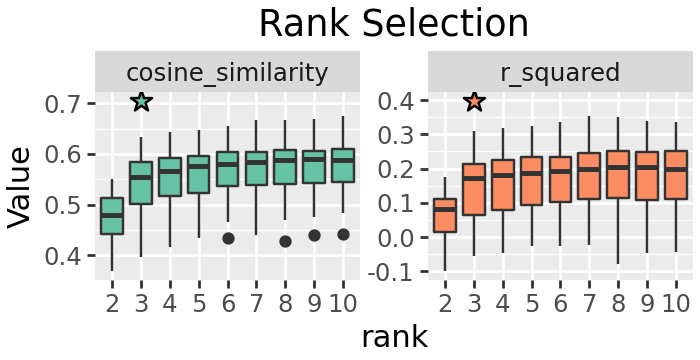

In [7]:
plt_ranksel = (
    denovo.plot_rank_selection(rank_res, jitter=False) + 
    pn.guides(fill = "none") +
    pn.theme(figure_size=(3.5, 1.8)) + 
    pn.ggtitle("Rank Selection")
)
plt_ranksel.save("cell_imgs/a_ranksel.pdf")
plt_ranksel

## Regularisation selection
We would like a sparse solution so we will use L1 regularisation, and select a value for parameter alpha. Regularisation selection is performed in much the same way, however the results returned are a tuple with the first element the suggested best value for alpha based on a heuristic, the second element being results in the same structure as rank selection.

In [8]:
best_alpha, regu_res = denovo.regu_selection(
    x=composition,
    rank=3,
    seed=4298,
    l1_ratio=1.0,
    progress_bar=False
)

/home/kam24goz/repos/cvanmf/src/cvanmf/denovo.py:1171: FutureWarning: The previous implementation of stack is deprecated and will be removed in a future version of pandas. See the What's New notes for pandas 2.1.0 for details. Specify future_stack=True to adopt the new implementation and silence this warning.
/home/kam24goz/repos/cvanmf/src/cvanmf/denovo.py:1275: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
/home/kam24goz/miniforge3/envs/cvanmf/lib/python3.12/site-packages/plotnine/ggplot.py:606: PlotnineWarning: Saving 3.5 x 1.8 in image.
/home/kam24goz/miniforge3/envs/cvanmf/lib/python3.12/site-packages/plotnine/ggplot.py:607: PlotnineWarning: Filename: cell_imgs/a_regusel.pdf


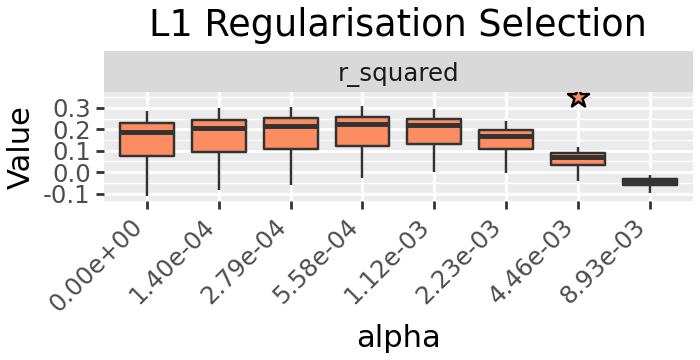

In [9]:
plt_regusel = (
    denovo.plot_regu_selection(regu_res, jitter=False) 
    + pn.theme(
        figure_size=(3.5, 1.8),
        axis_text_x=pn.element_text(rotation=45, hjust=1.0)
    )
    + pn.guides(fill = "none")
    + pn.ggtitle("L1 Regularisation Selection")
)
plt_regusel.save("cell_imgs/a_regusel.pdf")
plt_regusel

In [10]:
best_alpha

0.004464285714285714

The heuristic suggested value is quite a drop in $R^2$ compared to the previous, so we will instead take the value one before.

## Decomposition with selected parameters

In [11]:
decomps = denovo.decompositions(
    x=composition,
    ranks=[3],
    alpha=2.23e-03,
    l1_ratio=1.0,
    seed=4298,
    top_n=100
)
k3 = decomps[3][0]
# k3.name_signatures_by_weight(max_char_length=200, max_num_features=1)

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:01<00:00, 93.23it/s]


### Model fit for disease status

Dose our model describe certain diseases types better than others? We can plot the model fit for each sample, grouped by disease status. The model fit is relatively good for all groups, though slightly higher for all the cancer samples. We could hypothesise that this might be that there is more variation in composition among healthy participants; or perhaps as there are more cancer samples the model has learnt those types better.

/home/kam24goz/miniforge3/envs/cvanmf/lib/python3.12/site-packages/plotnine/ggplot.py:606: PlotnineWarning: Saving 3 x 1.5 in image.
/home/kam24goz/miniforge3/envs/cvanmf/lib/python3.12/site-packages/plotnine/ggplot.py:607: PlotnineWarning: Filename: cell_imgs/b_modelfit.pdf


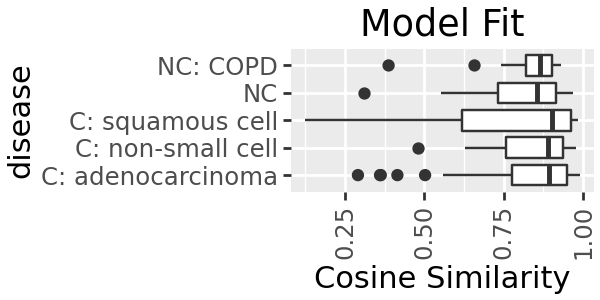

In [12]:
plt_modelfit = (
    k3.plot_modelfit(group=sample_md['disease']) 
    + pn.coord_flip() 
    + pn.theme(figure_size=(3, 1.5)) 
    + pn.ggtitle("Model Fit")
)
plt_modelfit.save("cell_imgs/b_modelfit.pdf")
plt_modelfit

We can do the same for tumour stage

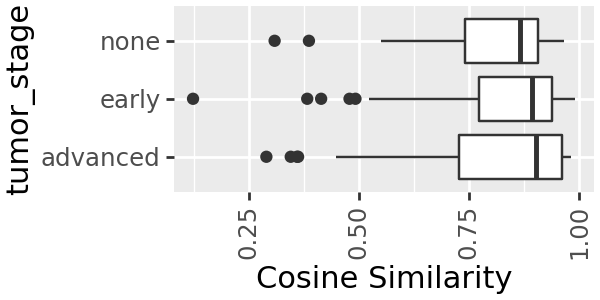

In [13]:
k3.plot_modelfit(group=sample_md['tumor_stage']) + pn.coord_flip() + pn.theme(figure_size=(3, 1.5))

### Ordination of samples

To look at broad patterns in the data, we can look at PCoA ordination of samples. With few signatures, these willl largely divide by primary signature. In the PCoA below, we can see cancer and non-cancer samples separating along the first axis, and early and late stage tumors separating on the second axis. 

We could run the PCoA on the input data, or WH, using the `on` argument of `plot_pcoa`/`pcoa`.

/home/kam24goz/repos/cvanmf/src/cvanmf/denovo.py:3721: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
/home/kam24goz/repos/cvanmf/src/cvanmf/denovo.py:3725: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
/home/kam24goz/miniforge3/envs/cvanmf/lib/python3.12/site-packages/plotnine/ggplot.py:606: PlotnineWarning: Saving 4.3 x 2.8 in image.
/home/kam24goz/miniforge3/envs/cvanmf/lib/python3.12/site-packages/plotnine/ggplot.py:607: PlotnineWarning: Filename: cell_imgs/c_pcoa.pdf


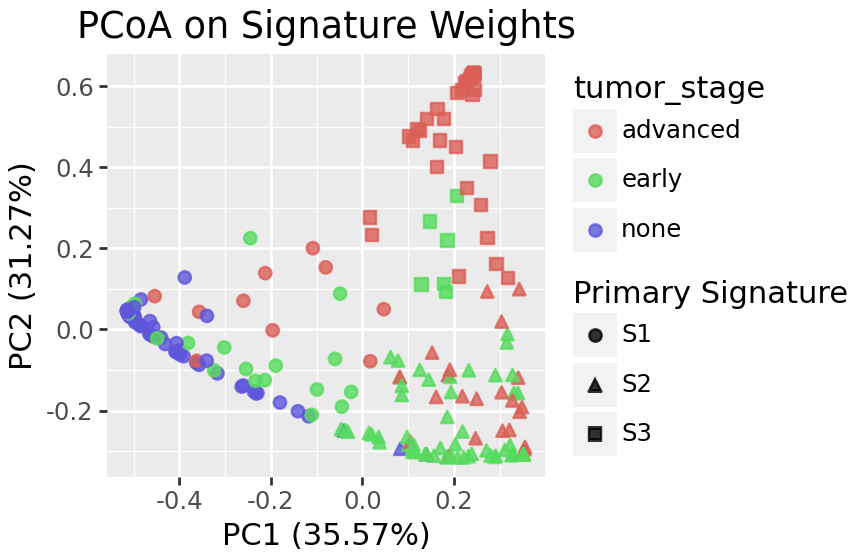

In [14]:
plt_pcoa = (
    k3.plot_pcoa(on="h", color=sample_md['tumor_stage'], shape="signature") 
    + pn.theme(figure_size=(4.3, 2.8)) 
    + pn.ggtitle("PCoA on Signature Weights")
)
plt_pcoa.save("cell_imgs/c_pcoa.pdf")
plt_pcoa

### Visualising signature composition

An overview of the signature composition for samples can be a useful exploratory step. The `plot_relative_weight` methods produces a combination of stacked bar plot, a ribbon indicating some categorical metadata value for each sample, and a point plot of model fit.

Here we can see again what we observed above - there is a shift in S2 / S3 abundance between early and late stage tumours, and S3 is more abundant in advanced tumors.

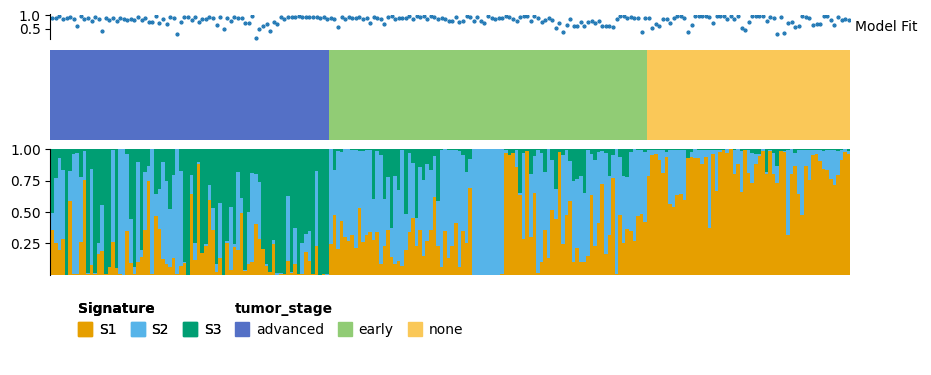

In [15]:
fig = k3.plot_relative_weight(group=sample_md['tumor_stage'].sort_values(), heights=[0.25, 0.9, 0.1, 0.1], 
                        sample_label_size=False, legend_cols_h=3, width=8, point_size=0.1,
                        threshold=None)
# The relative weight plot is produced by Marsilea, so unfortunately currently has a slightly different way to display and save
fig.save("cell_imgs/d_relative_weight.pdf")
plt.show()

### Interpreting signatures

Knowing which features contribute to each signature can help give a domain-specific interpretation, such as understanding which types of cells are contributing to the cancer associated signature.

The default plot for this is `plot_feature_weight`, which shows all features above a certain proportion of the overall signature weights (by default 4%).

Here we see S2 is largely immune type / T-cells, S3 malignant cancer cells, and S1 a mix including functional lung cells (pneumocyte, alveolar macrophage).

/home/kam24goz/miniforge3/envs/cvanmf/lib/python3.12/site-packages/plotnine/scales/scales.py:48: PlotnineWarning: Scale for 'x' is already present.
Adding another scale for 'x',
which will replace the existing scale.

/home/kam24goz/miniforge3/envs/cvanmf/lib/python3.12/site-packages/plotnine/ggplot.py:606: PlotnineWarning: Saving 3.9 x 2.5 in image.
/home/kam24goz/miniforge3/envs/cvanmf/lib/python3.12/site-packages/plotnine/ggplot.py:607: PlotnineWarning: Filename: cell_imgs/f_feature_weight.pdf


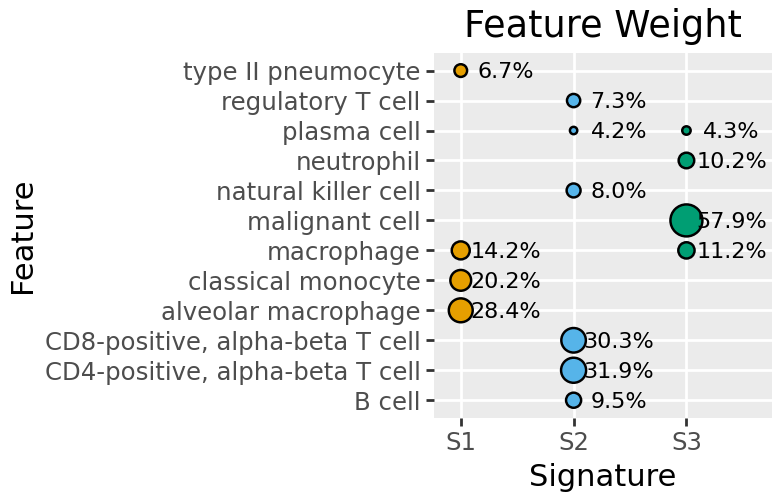

In [16]:
plt_weight = (
    k3.plot_feature_weight() 
    + pn.theme(
        figure_size=(3.9,2.5)
    )
    + pn.ggtitle("Feature Weight")
    + pn.scale_x_discrete(expand=(0.1, 0.0, 0.15, 0.0)) # This adds a little more room left and right of the bubbles
)
plt_weight.save("cell_imgs/f_feature_weight.pdf")
plt_weight

In [17]:
sample_md.columns
k3.names = ['S1', 'S2', 'S3']

### Relationships to metadata

Throught the previous plots we have seen what look like some associations between tumor stage and signature. We can plot this relationship to metadata as box or scatter plots. `plot_metadata` takes a single datframe with all the metadata we want to plot against, and returns two figures with discrete and continuous variables respectively.

By default, statistical tests are run for discrete comparison: a Kruskal-Wallis test for more than two classes, and a Mann-Whitney U-test for two samples. Significance is indicated with stars.

Here, we see that there are differences in signature weight between disease and tumour stage.

/home/kam24goz/repos/cvanmf/src/cvanmf/denovo.py:4970: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
/home/kam24goz/repos/cvanmf/src/cvanmf/denovo.py:4142: FutureWarning: The provided callable <function min at 0x7fb52807dc60> is currently using DataFrameGroupBy.min. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "min" instead.
/home/kam24goz/repos/cvanmf/src/cvanmf/denovo.py:4158: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
/home/kam24goz/repos/cvanmf/src/cvanmf/denovo.py:4163: FutureWarning: The default of observed=False is deprecated and will b

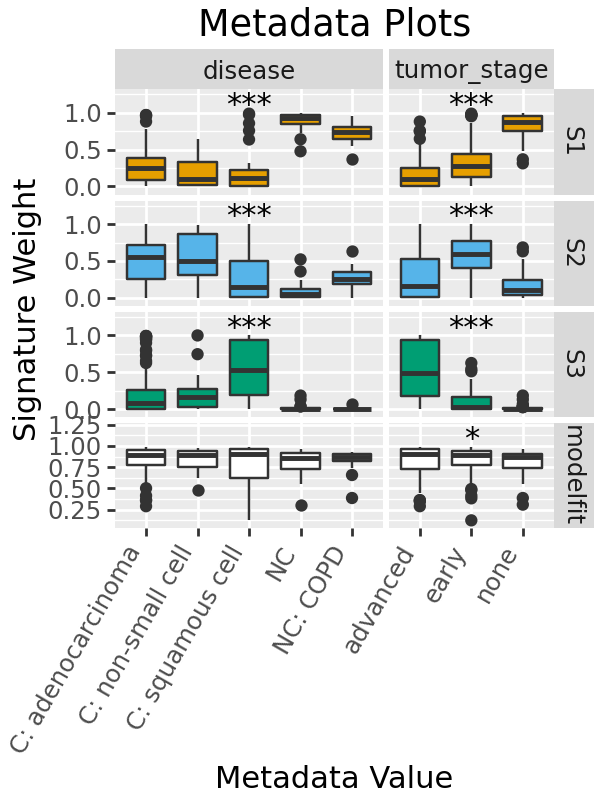

In [18]:
disc, cont = k3.plot_metadata(sample_md[['disease', 'tumor_stage', 'age']])
disc = (
    disc 
    + pn.guides(fill="none") 
    + pn.theme(
        figure_size=(3,4),
        axis_text_x=pn.element_text(rotation=60, hjust=1, vjust=1)
    )
    + pn.ggtitle("Metadata Plots")
    + pn.scale_y_continuous(expand=[0.1, 0, 0.2, 0]) # We're adding a little more room for the stars - the internal calculation doesn't always get the right space for custom size plots
)
disc.save("cell_imgs/e_metadata.pdf")
disc

We also get a plot for continuous metadata variables, though there is not much interesting to see here.

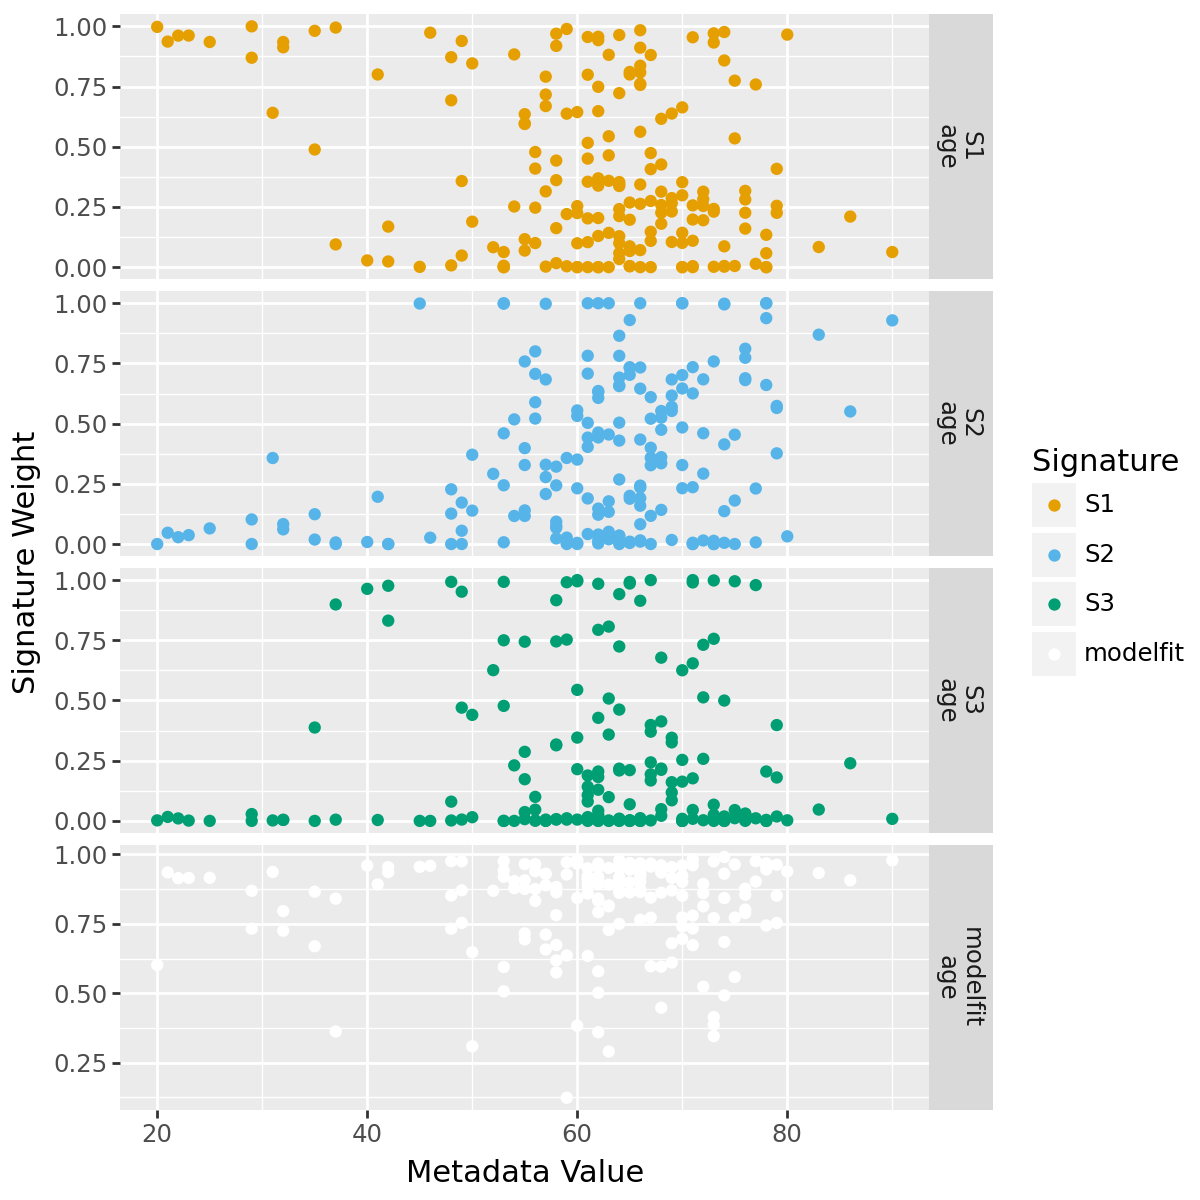

In [19]:
cont + pn.theme(figure_size=(6, 6))

### Stability of Signatures
NMF solutions vary depending on their initialisation - most methods offered include some randomisation, so solutions can vary.
If highly similar signatures are obtained across random initialisations, this can help characterise how robust each signature is.
Using the 100 decompositions we produced earlier, we can visualise how similar the signatures in other decompositions are to the best decomposition which we used for analysis.

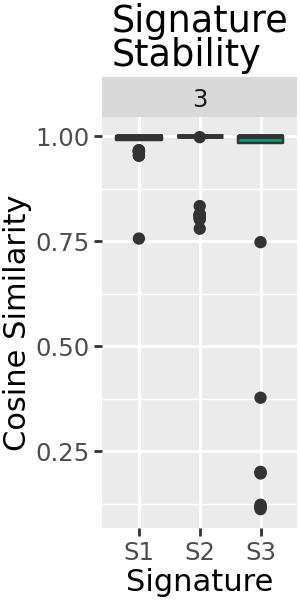

In [20]:
sig_stability = stability.signature_stability(
    decomps[3],
    decomps[3][0]
)
plt_stability = (
    stability.plot_signature_stability(
        sig_stability,
        k3.colors
    ) +
    pn.ggtitle("Signature\nStability") +
    pn.theme(figure_size=(1.5, 3)) +
    pn.guides(fill="none")
)
plt_stability

Signatures are mostly highly similar across decompositions, with a handful of outliers where the solution is more different.
In particular, signature S3 seems to have no similar signature in some decompositions.

We can compare this across decompositions of multiple ranks to see if signature stability supports our choice of rank.

In [21]:
decomps_multi = denovo.decompositions(
    x=composition,
    ranks=range(2, 11),
    # Suitable alpha hasn't been selected for all ranks, so set to 0
    alpha=0.0,
    l1_ratio=1.0,
    seed=4298,
    # We want to retain all our decompositions so we can compare them
    top_n=101,
    # We choose 101 so we can take the best, and compare it to 100 others
    random_starts=101,
    progress_bar=False
)

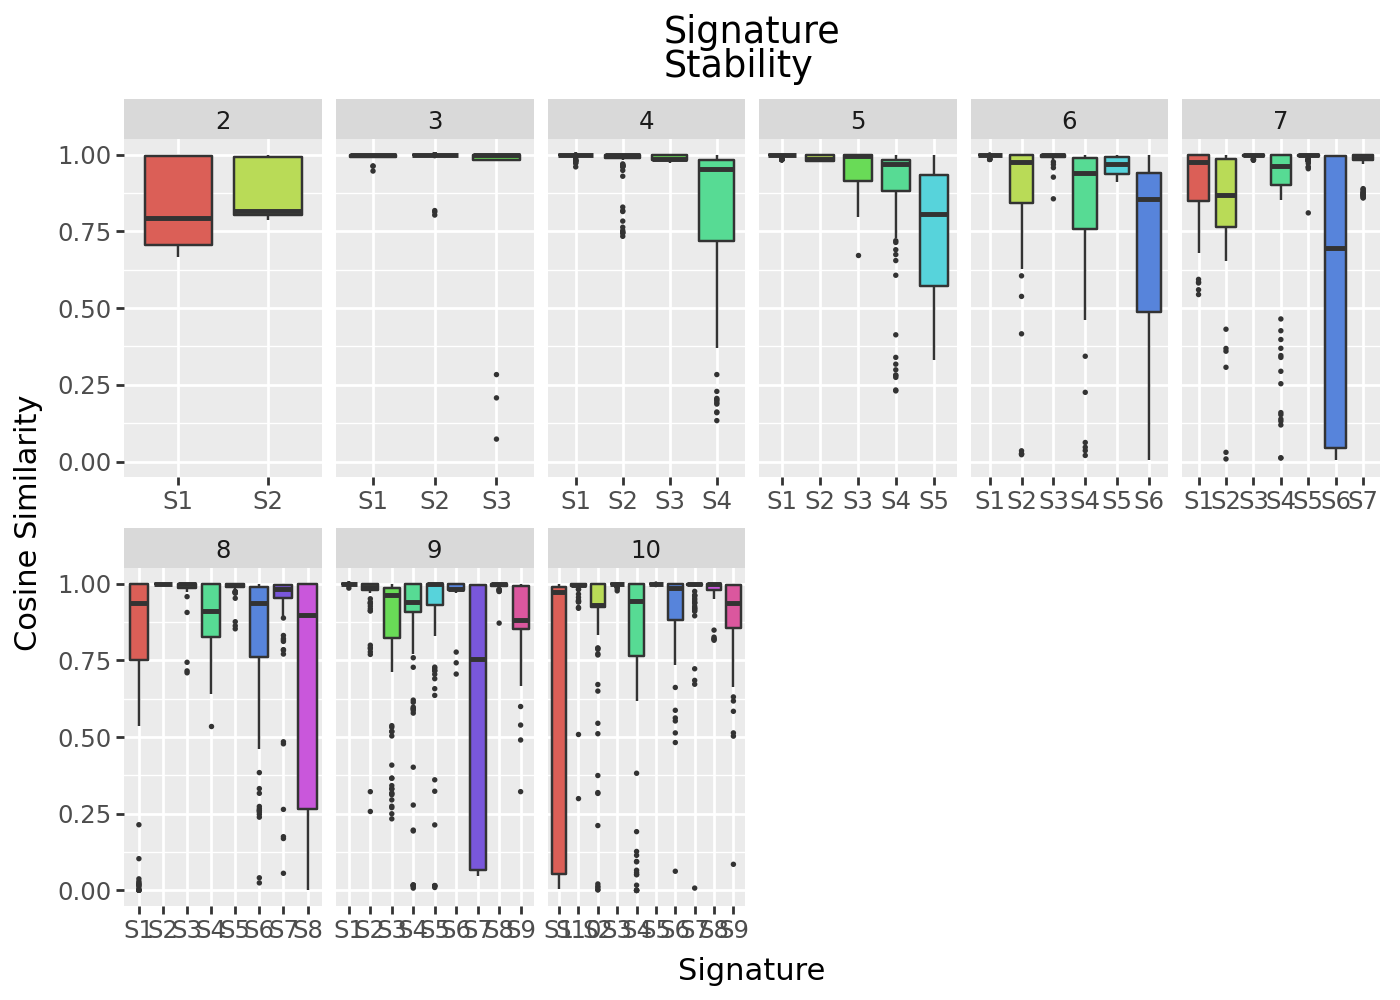

In [22]:
sig_stability_multi = stability.signature_stability(
    decomps_multi
)
plt_stability_multi = (
    stability.plot_signature_stability(
        sig_stability_multi,
        geom_boxplot=dict(outlier_size=0.1),
        geom_line=True
    ) +
    pn.ggtitle("Signature\nStability") +
    pn.theme(figure_size=(7, 5)) +
    pn.guides(fill="none") +
    pn.facet_wrap(facets="k", ncol=6, scales="free_x")
)
plt_stability_multi

The signatures here show much more variation across intialisations, suggesting a stable solution is not being found.